# 2. NYC Taxi: Работа с геоданными

Чтобы сдать задание, выполните следующую последовательность действий:

1. Загрузите агрегированные данные о поездках в мае 2016. Просуммируйте общее количество поездок такси из каждой географической зоны и посчитайте количество ячеек, из которых в мае не было совершено ни одной поездки.
2. Нарисуйте статическую карту Нью-Йорка. Поставьте на карте точку там, где находится Эмпайр-Стейт-Билдинг.
3. Поверх статической карты Нью-Йорка визуализируйте данные о поездках из каждой ячейки так, чтобы цветовая шкала, в которую вы окрашиваете каждую ячейку, показывала суммарное количество поездок такси из неё.
4. Вставьте интерактивную карту Нью-Йорка — такую, которую можно прокручивать и увеличивать. Поставьте метку там, где находится статуя свободы.
5. Нарисуйте на интерактивной карте Нью-Йорка ячейки так, чтобы их цвет показывал среднее за месяц количество поездок такси в час из этой зоны.
6. Чтобы не выбирать из всех 2500 ячеек вручную, отфильтруйте ячейки, из которых в мае совершается в среднем меньше 5 поездок в час. Посчитайте количество оставшихся. Проверьте на карте, что среди этих ячеек нет таких, из которых поездки на самом деле невозможны.
7. Сохраните ноутбук в формате html, запакуйте ipynb и html в один архив и загрузите его в форму (html облегчит задачу проверки вашим рецензентам — в ipynb динамические карты часто не сохраняются, а для выполнения кода рецензентам придётся устанавливать все библиотеки).

In [1]:
import pandas as pd
import numpy as np
import pickle
from geopy.geocoders import Nominatim

# basemap уже умирает, и версия 2.1 matplotlib выводит разные deprecated на его действия
# чтоб это не раздражало, отключим
import warnings
warnings.filterwarnings('ignore')

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 0. Подготовка данных

In [3]:
# зададим границы нашего квадрата
WEST_POINT = -74.25559
EAST_POINT = -73.70001
SOUTH_POINT = 40.49612
NORTH_POINT = 40.91553

In [4]:
# чтобы не воспроизводить длительное чтение и очистку данных первой недели,
# агрегированные данные были записаны в формате pkl; теперь просто считаем их
data_agr = pd.read_pickle('agr_tripdata_2016-05.pkl')

In [5]:
data_agr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860000 entries, 0 to 1859999
Data columns (total 3 columns):
date    datetime64[ns]
bins    int16
numb    int16
dtypes: datetime64[ns](1), int16(2)
memory usage: 21.3 MB


In [6]:
data_agr.head()

,date,bins,numb
0,2016-05-01,1,0
1,2016-05-01,2,0
2,2016-05-01,3,0
3,2016-05-01,4,0
4,2016-05-01,5,0


In [7]:
# таблица с идентификаторами ячеек
cells = pd.read_csv('regions.csv', header=0, delimiter=';', dtype={'region': 'int16'})

In [8]:
cells.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 5 columns):
region    2500 non-null int16
west      2500 non-null float64
east      2500 non-null float64
south     2500 non-null float64
north     2500 non-null float64
dtypes: float64(4), int16(1)
memory usage: 83.1 KB


In [9]:
cells.head()

,region,west,east,south,north
0,1,-74.25559,-74.244478,40.496120,40.504508
1,2,-74.25559,-74.244478,40.504508,40.512896
2,3,-74.25559,-74.244478,40.512896,40.521285
3,4,-74.25559,-74.244478,40.521285,40.529673
4,5,-74.25559,-74.244478,40.529673,40.538061


## 1. Зоны без поездок

In [10]:
# создаем группировочный объект, который агрегирует количество поездок по номерам ячеек
grouped = data_agr['numb'].groupby(data_agr['bins'])

In [11]:
print('количество ячеек, из которых не было совершено ни одной поездки - ', grouped.sum().value_counts()[0])

количество ячеек, из которых не было совершено ни одной поездки -  1283


## 2. Статичная карта NY с отметкой ESB

In [12]:
# для рисования статичных карт используем умирающий basemap
from mpl_toolkits.basemap import Basemap

In [13]:
%%time
# в разрешении full карта готовится довольно-таки медленно, 
# но даже в разрешении high, на нужном масштабе, карта выглядит убого
ny_map = Basemap(projection='merc', llcrnrlat=SOUTH_POINT, urcrnrlat=NORTH_POINT,
            llcrnrlon=WEST_POINT, urcrnrlon=EAST_POINT, resolution='f', area_thresh=0.01)

Wall time: 41.5 s


In [14]:
# определим координаты Empire State Building
geolocator = Nominatim()
location = geolocator.geocode("Empire State Building NYC")
ESB_LONGITUDE = location.longitude
ESB_LATITUDE = location.latitude
print('координаты Empire State Building - ', (round(ESB_LATITUDE, 6), round(ESB_LONGITUDE, 6)))

координаты Empire State Building -  (40.748428, -73.985655)


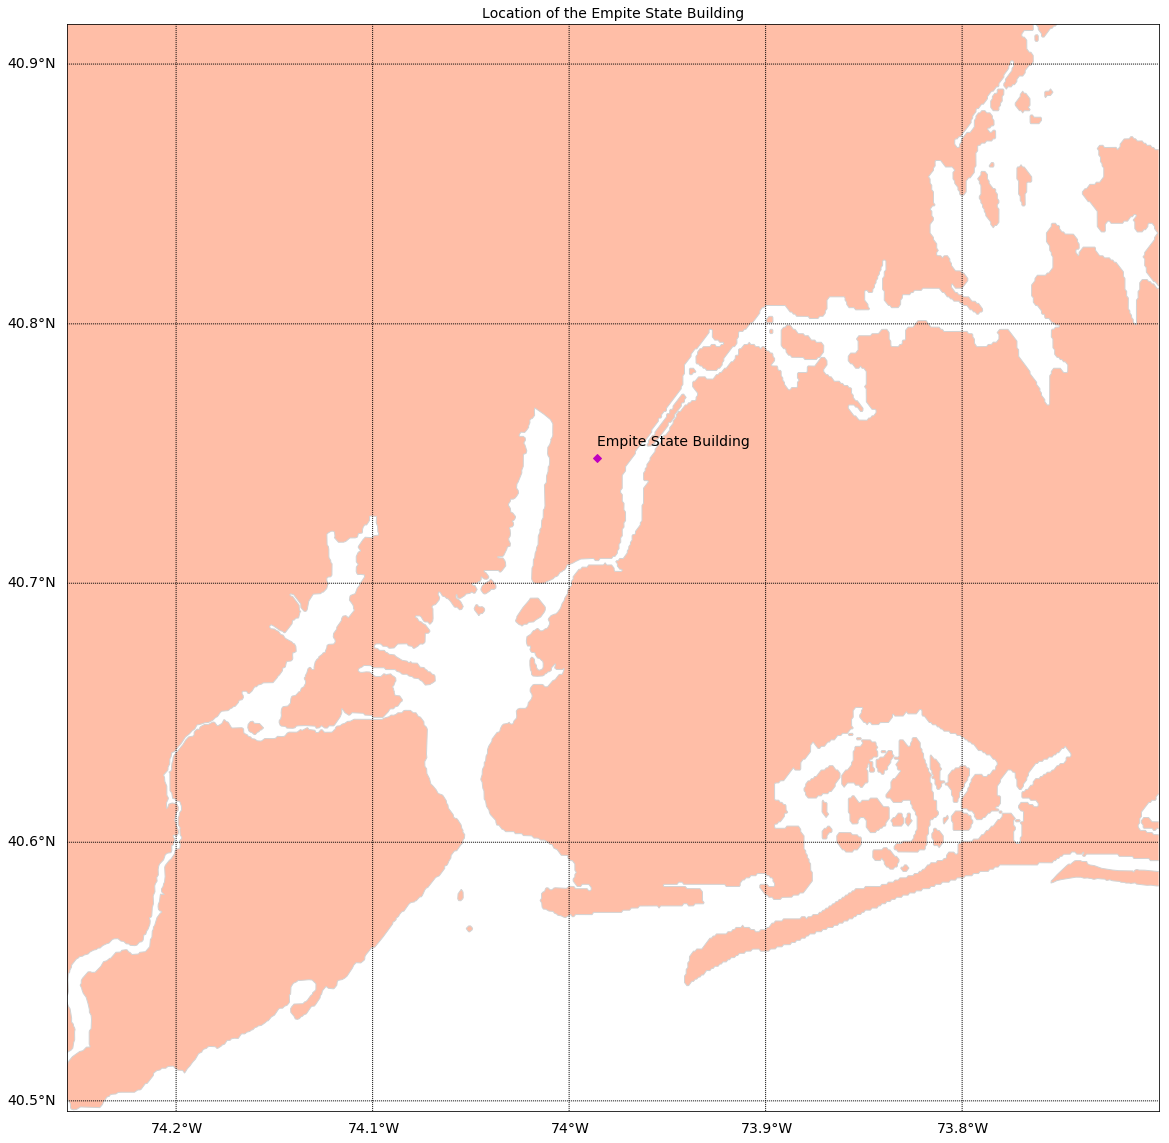

In [15]:
fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111)

# рисуем карту
ny_map.fillcontinents(color='coral',lake_color='aqua', alpha=0.5)
ny_map.drawcoastlines(color='lightgray')
ny_map.drawrivers(color='#0000ff') # реки не нарисовал...
ny_map.drawparallels(np.arange(40.5,41.0,.1),labels=[1,0,0,0], fontsize =14)
ny_map.drawmeridians(np.arange(-74.3,-73.7,.1),labels=[0,0,0,1], fontsize =14)

# ставим точку на карте
x, y = ny_map(ESB_LONGITUDE, ESB_LATITUDE)
ny_map.plot(x, y, marker='D',color='m')
plt.text(x, y+500, 'Empite State Building', fontsize=14, va='bottom')
plt.title("Location of the Empite State Building", fontsize =14)
plt.show()

## 3. Статичная карта NY с разбивкой на ячейки

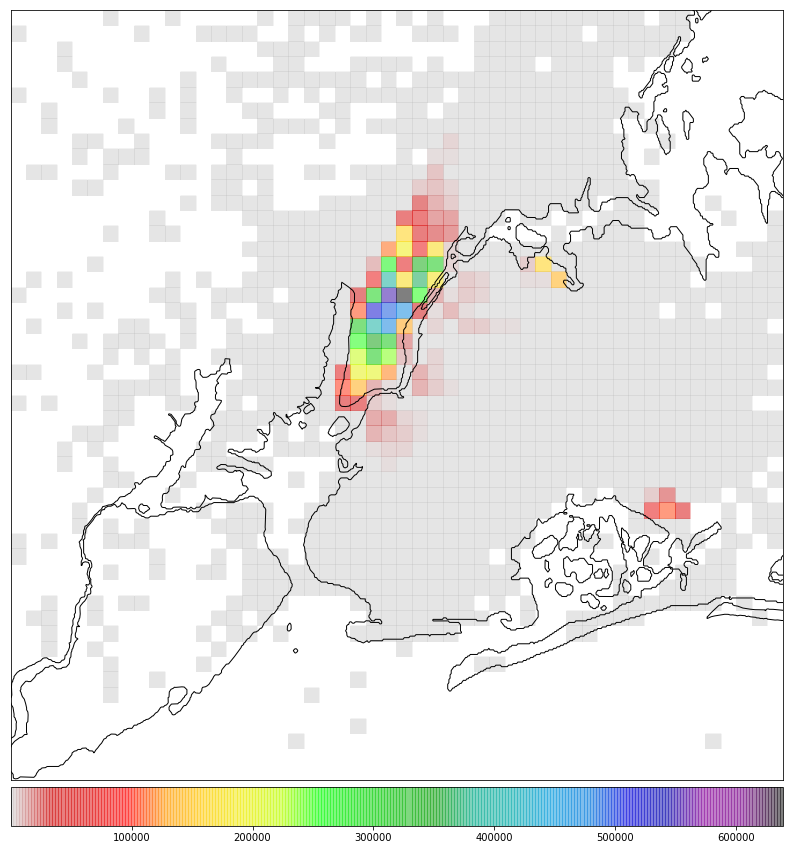

In [16]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111)

# создаем координатную сетку 50х50 ячеек
lons, lats = ny_map.makegrid(51, 51)
x, y = ny_map(lons, lats)

# создаем объект палитры и указываем цвет для "аномальных" значений
# "аномальными" будем считать те, откуда не совершено ни одной поездки за месяц
mycmap = cm.get_cmap('nipy_spectral_r')
mycmap.set_under('w') # аномалии красим белым

# рисуем карту
ny_map.drawcoastlines()
cs = ny_map.pcolormesh(x, y, (np.asarray(grouped.sum()).reshape([50,50]).T), cmap=mycmap, vmin=1, alpha=0.5)
cbar = ny_map.colorbar(cs, location='bottom', pad="1%")
plt.show()
"""
Итого:
Из белых ячеек не cовершено ни одной поездки за месяц, из серых - от одной, далее - по спекрту...
Как мы убедились выше, белых ячеек чуть более половины. Имеются ячейки, из которых зафиксированы поездки,
но они находятся в далеко заливе. Все они серые, т.е. явление не массовое.

В основном точки начала поездок сосредоточены на Манхэттене и у двух аэропортов.
Остальные ячейки исследуемого квадрата сильно отстают. Если рассматривать статистику общего количества
поездок по всем точкам за май 2016, то оказывается что от медиана равна 0, а 75% квантиль - 9,
то есть из 75% ячеек за месяц совершено от 0 до 9 поездок. При том, что в из самой горячей точки
их совершено почти 640 тысяч! То есть в среднем каждые 4 секунды оттуда стартует такси!
"""
pass

In [17]:
grouped.sum().describe()

count      2500.000000
mean       4650.608400
std       37485.826922
min           0.000000
25%           0.000000
50%           0.000000
75%           9.000000
max      638799.000000
Name: numb, dtype: float64

## 4. Интерактивная карта NY с отметкой Статуи Свободы

In [18]:
# для построения интерактивных карт используем folium
import folium
from folium import features

In [19]:
# определим координаты Статуи Свободы
location = geolocator.geocode("Statue of Liberty")
SL_LONGITUDE = location.longitude
SL_LATITUDE = location.latitude
print('координаты Статуи Свободы - ', (round(SL_LATITUDE, 6), round(SL_LONGITUDE, 6)))

координаты Статуи Свободы -  (40.689247, -74.044541)


In [20]:
# нанесение маркера - очень просто
m = folium.Map([40.75, -74.00], zoom_start=12)
mk = features.Marker([SL_LATITUDE, SL_LONGITUDE])
pp = folium.Popup('Statue of Liberty')
ic = features.Icon(color='red')

mk.add_child(ic)
mk.add_child(pp)
m.add_child(mk)

m

## 5. Интерактивная карта NY с разбивкой на ячейки

In [21]:
m = folium.Map([40.75, -74.00], zoom_start=10)

# для нанесения нешего размеченного квадрата готовим список словарей а-ля GeoJSON
# подробнее о формате GoeJSON: https://tools.ietf.org/html/rfc7946
crd = [
       {"type": "Feature",
        "id": int(x[0]),
        "bbox": list(x[1:]),
        "geometry": {
            "type": "Polygon",
            "coordinates": [[[x[1], x[3]], [x[1], x[4]], [x[2], x[4]], [x[2], x[3]]]]
        }
       }
    for x in cells.values]

geo_data = {"type": "FeatureCollection",
            "features": crd}

# к сожалению, на данный момент, нет простого способа сделать всплывающие окна к каждому квадрату,
# если квадраты заданы коллекцией объектов; но такая перспектива обсуждается на stackoverflow; уже год...
m.choropleth(
    geo_data=geo_data,
    name='Aver_Taxi_Numb',
    data=grouped.mean(),
    columns=['numb'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average number of a taxi',
    threshold_scale = [-20., 20., 300., 500., 700., 900.])
  
folium.LayerControl().add_to(m)

m

## 6. Фильтрация ячеек

In [22]:
print('из {} ячеек совершалось в среднем более 5 поездок в час'.format(grouped.mean()[grouped.mean() > 5].shape[0]))

из 102 ячеек совершалось в среднем более 5 поездок в час


In [23]:
# покажем на карте только эти ячейки

# отбираем данные в агрегированной таблице и в таблице координат ячеек 
filtered_data = grouped.mean()[grouped.mean() > 5]
keys = filtered_data.index
filtered_regs = cells.ix[keys-1]

# строим карту
m = folium.Map([40.75, -74.00], zoom_start=10)

crd = [
       {"type": "Feature",
        "id": int(x[0]),
        "bbox": list(x[1:]),
        "geometry": {
            "type": "Polygon",
            "coordinates": [[[x[1], x[3]], [x[1], x[4]], [x[2], x[4]], [x[2], x[3]]]]
        }
       }
    for x in filtered_regs.values]

geo_data = {"type": "FeatureCollection",
            "features": crd}

m.choropleth(
    geo_data=geo_data,
    name='Aver_Taxi_Numb',
    data=filtered_data,
    columns=['numb'],
    key_on='feature.id',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average number of a taxi',
    threshold_scale = [-20., 20., 300., 500., 700., 900.])
  
folium.LayerControl().add_to(m)

"""
На карте отображены 102 ячейки, из которых стартует в среднем пять и более такси в час (в мае 2016)
Ни одна из этих ячеек не находится полностью в воде. Вообще ячейки довольно-таки крупные, и если 
подробнее рассмотреть, например, Центральный парк, то закрывающие его ячейки,краями "заходят" в город,
т.е. утверждать, что в эти ячейки невозможен въезд такси - нельзя.
"""

m